#Looks like the original was probably 0.02 - 0.01*fortification but was adjusted each season
#Season 12-14 = 0.019 - 0.01*dfc["ballpark_fortification"]
#Season 15 = 0.02 - 0.0125*dfc["ballpark_fortification"]

In [2]:
import glob

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.markers import CARETLEFTBASE, CARETRIGHTBASE
from csv_dtypes import column_dtypes

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

In [3]:
all_files = glob.glob("../roll_data/*-c1.csv")

df = pd.concat((pd.read_csv(f, dtype=column_dtypes) for f in all_files), ignore_index=True)

# seasons = [11, 12]
seasons = [11,12,13,14]
# seasons = [14]
# seasons = [13, 14]
df = df[df['season'].isin(seasons)]
len(df)

11120

In [4]:
dfc = df.copy()
for exclude_mod in []:
    dfc = dfc[~dfc["batter_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitcher_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["pitching_team_mods"].astype(str).str.contains(exclude_mod)]
    dfc = dfc[~dfc["batting_team_mods"].astype(str).str.contains(exclude_mod)]
for exclude_mod in []:
    dfc = dfc[~dfc["fielder_mods"].astype(str).str.contains(exclude_mod)]


batter_params = ['batter_buoyancy', 'batter_divinity', 'batter_martyrdom', 'batter_moxie', 'batter_musclitude', 'batter_patheticism', 'batter_thwackability', 'batter_tragicness', 'batter_coldness', 'batter_overpowerment', 'batter_ruthlessness', 'batter_shakespearianism', 'batter_suppression', 'batter_unthwackability', 'batter_base_thirst', 'batter_continuation', 'batter_ground_friction', 'batter_indulgence', 'batter_laserlikeness', 'batter_anticapitalism', 'batter_chasiness', 'batter_omniscience', 'batter_tenaciousness', 'batter_watchfulness', 'batter_pressurization', 'batter_cinnamon']
pitcher_params = ['pitcher_buoyancy', 'pitcher_divinity', 'pitcher_martyrdom', 'pitcher_moxie', 'pitcher_musclitude', 'pitcher_patheticism', 'pitcher_thwackability', 'pitcher_tragicness', 'pitcher_ruthlessness', 'pitcher_overpowerment', 'pitcher_unthwackability', 'pitcher_shakespearianism', 'pitcher_suppression', 'pitcher_coldness', 'pitcher_base_thirst', 'pitcher_continuation', 'pitcher_ground_friction', 'pitcher_indulgence', 'pitcher_laserlikeness', 'pitcher_anticapitalism', 'pitcher_chasiness', 'pitcher_omniscience', 'pitcher_tenaciousness', 'pitcher_watchfulness', 'pitcher_pressurization', 'pitcher_cinnamon']
fielder_params = ['fielder_anticapitalism', 'fielder_chasiness', 'fielder_omniscience', 'fielder_tenaciousness', 'fielder_watchfulness']
for attr in batter_params:
    dfc[attr] = dfc[attr] * df['batter_multiplier']
for attr in pitcher_params:
    dfc[attr] = dfc[attr] * df['pitcher_multiplier']


dfc.loc[dfc["pitcher_mods"].astype(str).str.contains("SCATTERED"),"pitcher_vibes"] = 0
dfc.loc[dfc["batter_mods"].astype(str).str.contains("SCATTERED"),"batter_vibes"] = 0
dfc.loc[dfc["fielder_mods"].astype(str).str.contains("SCATTERED"),"fielder_vibes"] = 0

dfc = dfc[dfc["batter_multiplier"] == 1]
dfc = dfc[dfc["pitcher_multiplier"] == 1]


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import svm, linear_model

dfc["fort"] = dfc["ballpark_fortification"] - 0.5

X = dfc[["roll", "ballpark_fortification"]]
y = dfc['passed']

sc = StandardScaler()
X2 = sc.fit_transform(X)

trainedsvm = svm.LinearSVC(dual=False, C=500000, max_iter=5000000, tol=1e-5).fit(X2, y)
predictionsvm = trainedsvm.predict(X2)
confusion_matrix(y,predictionsvm)

array([[8871,    0],
       [   0,  129]], dtype=int64)

In [6]:
coef = np.true_divide(trainedsvm.coef_, sc.scale_)
coef_scaled = coef / coef[0, 0]
coef_list = coef_scaled.tolist()[0]
sorted(zip(coef_list, X.columns), key=lambda x: abs(x[0]), reverse=True)

[(1.0, 'roll'), (0.013023248625305362, 'ballpark_fortification')]

In [7]:
intercept = trainedsvm.intercept_ - np.dot(coef, sc.mean_)
intercept_scaled = intercept / coef[0, 0]
intercept_scaled

array([-0.0205378])

In [8]:
print(len(dfc[~dfc["passed"]]))
print(len(dfc[dfc["passed"]]))

8871
129


In [12]:
fort = dfc["ballpark_fortification"] - 0.5

#Looks like the original was probably 0.02 - 0.01*fortification but was adjusted each season
#Season 12-14 = 0.019 - 0.01*dfc["ballpark_fortification"]
#Season 15 = 0.02 - 0.0125*dfc["ballpark_fortification"]
dfc["threshold"] = 0.02 - 0.01*dfc["ballpark_fortification"]

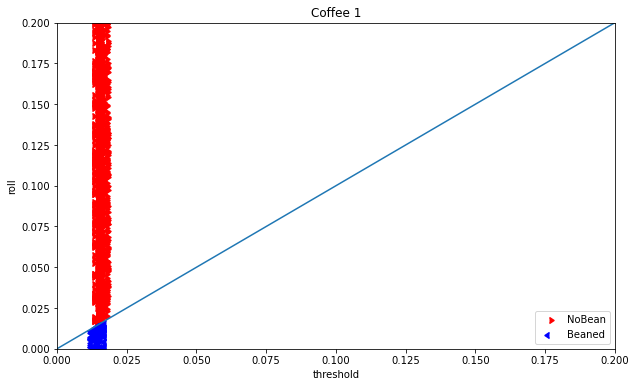

In [13]:
x_val = "threshold"
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.scatter(dfc[~dfc['passed']][x_val], dfc[~dfc['passed']]["roll"], color="red",
           label="NoBean", marker=CARETRIGHTBASE)
ax.scatter(dfc[dfc['passed']][x_val], dfc[dfc['passed']]["roll"], color="blue",
           label="Beaned", marker=CARETLEFTBASE)

ax.plot([0, 1], [0, 1])
ax.set_xlabel(x_val)
ax.set_ylabel('roll')
ax.set_title("Coffee 1")
ax.set_xlim([0.0, 0.2])
ax.set_ylim([0.0, 0.2])
ax.legend()

,offset,weather,event_type,fielder_mods,pitcher_overpowerment,roll,threshold,fielder_name,season,batter_name,pitcher_name,batter_mods,pitcher_mods,batting_team_mods,pitching_team_mods,day,game_id,play_count
9280,-0.001149,Weather.COFFEE,NoBean,<NA>,1.100612,0.012321,0.013470,<NA>,14,Kichiro Guerra,Finn James,ALTERNATE;MAXIMALIST;WIRED,WILD,LOVE,CARCINIZATION;UNHOLEY,79,229df7b4-a8d4-4949-9d74-941268a46ee6,297
10290,-0.000959,Weather.COFFEE,NoBean,<NA>,1.020226,0.013057,0.014017,<NA>,14,Eizabeth Elliott,PolkaDot Patterson,<NA>,SQUIDDISH;SWIM_BLADDER,O_NO,HIGH_PRESSURE,91,673cd98b-cb94-4b46-8590-82074ffde9c8,53
7372,-0.000900,Weather.COFFEE,NoBean,<NA>,0.471050,0.013906,0.014806,<NA>,14,Ortiz Lopez,Brock Forbes,FIRE_EATER,WILD,LOVE,CARCINIZATION;UNHOLEY,60,eebb949c-39e0-4d58-9bc4-a9e974ce3e85,45
8615,-0.000897,Weather.COFFEE,NoBean,<NA>,0.776169,0.013855,0.014752,<NA>,14,Valentine Games,Xandra Pancakes,EGO1,<NA>,SINKING_SHIP,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,72,06182bea-b2eb-4c9b-90ab-7043bad204fa,277
2101,-0.000656,Weather.COFFEE,NoBean,<NA>,0.405756,0.014344,0.015000,<NA>,12,Cory Ross,Beasley Gloom,SIPHON,<NA>,<NA>,EARLBIRDS,63,076befac-0b8a-41a4-8a4a-582f2d60f7f1,65
4726,-0.000438,Weather.COFFEE,NoBean,<NA>,0.725363,0.013573,0.014011,<NA>,13,Gia Holbrook,Orville Manco,<NA>,<NA>,MAINTENANCE_MODE,<NA>,86,addb1c7c-2cd2-4b37-bd8f-8da4e616054c,260
1499,-0.000408,Weather.COFFEE,NoBean,<NA>,1.370251,0.014592,0.015000,<NA>,12,Bees Taswell,Sandford Garner,<NA>,<NA>,MAINTENANCE_MODE,LOVE;EXTRA_STRIKE,7,a52ee168-fa89-4edd-86cd-880de9a7a17b,281
872,-0.000377,Weather.COFFEE,NoBean,<NA>,0.975465,0.014623,0.015000,<NA>,11,Paula Mason,Combs Estes,FIRE_EATER,SIPHON,FIREPROOF;SEALANT,<NA>,54,8f6a7e3b-5971-4790-8319-e206bfb221b8,14
4844,-0.000241,Weather.COFFEE,NoBean,<NA>,0.843811,0.014444,0.014685,<NA>,13,Stu Trololol,Oscar Vaughan,ALTERNATE;FLINCH,ALTERNATE,TRAVELING;PARTY_TIME,<NA>,90,fd8d22dc-89c7-41dd-83da-5ad9337527c1,123
9519,-0.000068,Weather.COFFEE,NoBean,<NA>,0.315023,0.014684,0.014752,<NA>,14,Cantus Hojo,Dunn Keyes,<NA>,ALTERNATE,BOTTOM_DWELLER;BLACKHOLE_PAYOUTS,GROWTH,80,be826818-68ee-4407-8e18-169cb41db31e,343


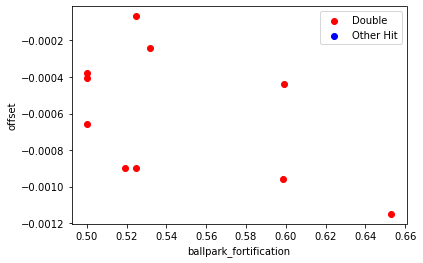

In [14]:
dfc["offset"] = dfc["roll"] - dfc["threshold"]
outliers = dfc[(dfc["passed"] & (dfc["offset"] > 0)) | (~dfc["passed"] & (dfc["offset"] < 0))]

fig, ax = plt.subplots(1)
x_val = "ballpark_fortification"
y_val = "offset"
ax.scatter(outliers[~outliers['passed']][x_val], outliers[~outliers['passed']][y_val], color="red", label="Double")
ax.scatter(outliers[outliers['passed']][x_val], outliers[outliers['passed']][y_val], color="blue", label="Other Hit")
ax.set_xlabel(x_val)
ax.set_ylabel(y_val)
ax.legend()

table = outliers
table[["offset", "weather", "event_type", "fielder_mods", "pitcher_overpowerment",
       "roll", "threshold",
       "fielder_name", "season",
       "batter_name", "pitcher_name", "batter_mods", "pitcher_mods",
       "batting_team_mods", "pitching_team_mods", "day",  "game_id", "play_count"]].sort_values('offset')


In [265]:
print(dfc[dfc["passed"]]["roll"].min())
print(dfc[~dfc["passed"]]["roll"].max())

0.0002648354734513525
0.9994472809302016
